In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from intake import open_catalog
import cartopy.crs as ccrs
from skimage.transform import resize

### Load and plot data example

In [2]:
from intake import open_catalog
cat = open_catalog("https://raw.githubusercontent.com/eurec4a/eurec4a-intake/master/catalog.yml")
ds = cat.satellites.GOES16.latlongrid.to_dask()
ds

<xarray.Dataset>
Dimensions:  (time: 1440, lat: 2640, lon: 2200)
Coordinates:
  * lat      (lat) float64 18.0 17.99 17.99 17.99 ... 8.013 8.009 8.006 8.002
  * lon      (lon) float64 -62.0 -61.99 -61.99 -61.98 ... -50.01 -50.01 -50.0
  * time     (time) datetime64[ns] 2020-02-02T00:00:48.400000 ... 2020-02-02T...
Data variables:
    C13      (time, lat, lon) float64 ...
Attributes: (12/14)
    title:                           Geostationary satellite imagery from GOE...
    description:                     GOES16 satellite data regridded on a reg...
    converted_by:                    Hauke Schulz (hauke.schulz@mpimet.mpg.de)
    institution:                     Max Planck Institute for Meteorology, Ha...
    Conventions:                     CF-1.7
    python_version:                  3.6.10 |Anaconda, Inc.| (default, Mar 23...
    ...                              ...
    version:                         --
    source:                          gcp-public-data-goes-16/ABI-L1b-RadM/202...
    history:                         Thu Dec 10 01:26:41 2020: ncrcat --no_tm...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...
    _NCProperties:                   version=2,netcdf=4.6.2,hdf5=1.8.21
    DODS_EXTRA.Unlimited_Dimension:  time

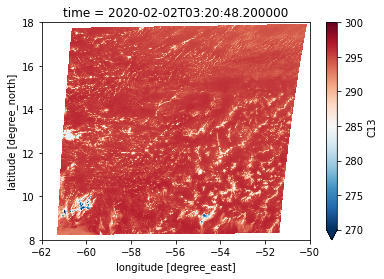

In [3]:
# Using Hauke's colour schemes
vmin = 270
vmax = 300
cmap = "RdBu_r"

test_scene = ds.C13.isel(time=200)
test_scene.plot(cmap=cmap, vmin=vmin, vmax=vmax)

### Define area subset and cloud mask following [Schulz et al. (2022)](https://doi.org/10.5194/essd-14-1233-2022).
- Longitude $\in$ [58-48] W, latitude $\in$ [10-20] N. **Note: Reduced here to [58-52] W and [10-16] N to avoid missing data.**
- Recast to equidistant grid, since ``cloudmetrics`` assumes ``dx=dy=constant``
- Cloudy pixels are C13 $\in$ [280-290] K
- Reject if 25<sup>th</sup> percentile of C13 < 285 (high clouds)

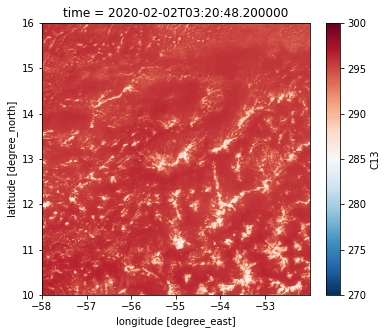

In [4]:
# Subset original image
lat0, lat1, lon0, lon1 = [10, 16, -58, -52]
T_high_min = 285

test_sub = test_scene.sel(lat=slice(lat1, lat0), lon=slice(lon0,lon1))
plt.figure(figsize=(6,5))
test_sub.plot(cmap=cmap, vmin=vmin, vmax=vmax)

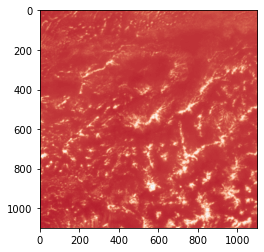

In [5]:
# Resize to square where dlat=dlon (with anti-aliasing). Don't know if this is wildly inappropriate.
imin = np.argmin(test_sub.shape)
test_sub_res = resize(test_sub, (test_sub.shape[imin],test_sub.shape[imin]), anti_aliasing=True)
plt.imshow(test_sub_res, cmap=cmap, vmin=vmin, vmax=vmax)

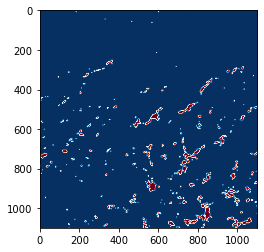

In [6]:
# Cloud mask
T_cl_min = 280
T_cl_max = 290

test_cm = np.zeros(test_sub_res.shape,dtype=int)
test_cm[(test_sub_res < T_cl_max) & (test_sub_res > T_cl_min)] = 1
plt.imshow(test_cm, cmap=cmap)

In [7]:
# Test high clouds
q_cutoff = 25
T_cutoff = 285

if np.percentile(test_sub_res[test_cm == 1], q_cutoff) < T_cutoff:
    print('Reject due to high clouds')

### Test a few metrics

In [8]:
import cloudmetrics

# Cloud mask metrics
print('cf   : ',cloudmetrics.mask.cloud_fraction(test_cm))
print('frac : ',cloudmetrics.mask.fractal_dimension(test_cm))
# print('open sky:', cloudmetrics.mask.open_sky(test_cm))

# Object metrics
# Could do this using cloud mask directly...
# print('iorg : ',cloudmetrics.mask.iorg_objects(test_cm, periodic_domain=False))
# print('scai : ',cloudmetrics.mask.scai_objects(test_cm, periodic_domain=False))
# print('cop  : ',cloudmetrics.mask.cop_objects(test_cm, periodic_domain=False))

# ...or using object labels explicitly (would need to make the mask periodic first yourself if periodic bcs)
object_labels = cloudmetrics.objects.label(test_cm)
print('iorg : ',cloudmetrics.objects.iorg(object_labels))
print('scai : ',cloudmetrics.objects.scai(object_labels))
print('cop  : ',cloudmetrics.objects.cop(object_labels))
print('max len  : ',cloudmetrics.objects.max_length_scale(object_labels))
print('mean len  : ',cloudmetrics.objects.mean_length_scale(object_labels))
print('mean ecc  : ',cloudmetrics.objects.mean_eccentricity(object_labels))
print('mean peri  : ',cloudmetrics.objects.mean_perimeter_length(object_labels))

# Scalar metrics
print('spectral : ',cloudmetrics.scalar.compute_all_spectral(test_sub_res))
print('woi1 :',cloudmetrics.scalar.woi1(test_sub_res))
print('woi2 :',cloudmetrics.scalar.woi2(test_sub_res))
print('woi3 :',cloudmetrics.scalar.woi3(test_sub_res))
print('mean :',cloudmetrics.scalar.mean(test_sub_res))
print('var :',cloudmetrics.scalar.var(test_sub_res))
# print('skew :',cloudmetrics.scalar.skew(test_sub_res)) # FIXME need to tell scipy.stats.skew to go None, not along 0 azis
# print('kurt :',cloudmetrics.scalar.kurtosis(test_sub_res)) # FIXME need to tell scipy.stats.skew to go None, not along 0 azis

# Alternative (explicit) computation of spectral metrics
# wavenumbers, psd_1d_radial, psd_1d_azimuthal = cloudmetrics.scalar.compute_spectra(test_sub_res)
# print('spec. len. mom. :', cloudmetrics.scalar.spectral_length_moment(wavenumbers, psd_1d_radial))


cf   :  0.02605702479338843
frac :  1.2107883471900498
iorg :  0.6772713422165311
scai :  0.22456245767851216
cop  :  0.027519590217294044
max len  :  43.23193264243457
mean len  :  10.052586094109673
mean ecc  :  0.8221711856564973
mean peri  :  39.60416700362295
spectral :  (0.7565176341571166, -0.6129942268679593, -0.3402059235281772, 91.66666666666667, 28.395464842852363)
woi1 : 0.22248654445921884
woi2 : 6.325952685627416e-07
woi3 : 0.25098919475222475
mean : 294.96439542972854
var : 2.369365808393956


## Compute and store `cloudmetrics` for all scenes

In [9]:
import inspect

metrics = ['cloud_fraction',
           'fractal_dimension',
           'open_sky',
           'cop',
           'iorg',
           'scai',
           'max_length_scale',
           'mean_eccentricity',
           'mean_length_scale',
           'mean_perimeter_length',
           'num_objects',
           'orientation',
           'spectral_length_moment',
           'spectral_anisotropy',
           'spectral_slope',
           'woi1',
           'woi2',
           'woi3'
          ]

# These are the metrics to choose from
available_mask_metrics = dict(inspect.getmembers(cloudmetrics.mask, inspect.isfunction))
available_object_metrics = dict(inspect.getmembers(cloudmetrics.objects, inspect.isfunction))
available_scalar_metrics = dict(inspect.getmembers(cloudmetrics.scalar, inspect.isfunction))
# available_metrics = {**available_mask_metrics, **available_scalar_metrics}

df_metrics = pd.DataFrame(index=ds['time'], columns=metrics)

### Main loop, using variable definitions from earlier cells

Processing  <xarray.DataArray 'time' ()>
array('2020-02-02T00:00:48.400000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-02-02T00:00:48.400000
Attributes:
    standard_name:  time
    axis:           T
    _ChunkSizes:    1 scene  1 / 1440
Computing cloud_fraction
Computing fractal_dimension
Computing open_sky
Computing cop
Computing iorg
Computing scai
Computing max_length_scale
Computing mean_eccentricity
Computing mean_length_scale
Computing mean_perimeter_length
Computing num_objects
Computing orientation
Computing spectral_length_moment
Computing spectral_anisotropy
Computing spectral_slope
Computing woi1
Computing woi2
Computing woi3
Processing  <xarray.DataArray 'time' ()>
array('2020-02-02T00:01:48.400000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-02-02T00:01:48.400000
Attributes:
    standard_name:  time
    axis:           T
    _ChunkSizes:    1 scene  2 / 1440
Computing cloud_fraction
Computing fractal_dimension
C

,cloud_fraction,fractal_dimension,open_sky,cop,iorg,scai,max_length_scale,mean_eccentricity,mean_length_scale,mean_perimeter_length,num_objects,orientation,spectral_length_moment,spectral_anisotropy,spectral_slope,woi1,woi2,woi3
2020-02-02 00:00:48.400,0.01187,1.138885,0.368241,0.022011,0.718486,0.23221,26.814175,0.811423,6.720615,24.861467,318,0.824377,21.692517,0.768199,-0.643033,0.178044,0.0,0.292485
2020-02-02 00:01:48.400,0.012085,1.143359,0.361865,0.021919,0.69797,0.238814,25.942244,0.804672,6.697449,24.864558,326,0.823416,21.741615,0.768423,-0.643123,0.178238,0.0,0.292289
2020-02-02 00:02:48.400,0.012446,1.143935,0.363403,0.022567,0.709032,0.23494,25.690465,0.808214,6.838873,25.350986,322,0.814749,21.7762,0.767195,-0.642206,0.1782,0.0,0.292004
2020-02-02 00:03:48.400,0.012421,1.138714,0.369919,0.022823,0.722827,0.230809,25.592968,0.794909,6.842692,25.086305,321,0.8164,21.799977,0.766638,-0.641905,0.178288,0.0,0.291939
2020-02-02 00:04:48.400,0.012546,1.143828,0.360521,0.022645,0.729747,0.239893,26.229754,0.797459,6.741817,24.608813,334,0.813272,21.818242,0.766428,-0.641874,0.178484,0.0,0.292336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-02 23:55:47.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-02 23:56:47.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-02 23:57:47.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-02 23:58:47.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


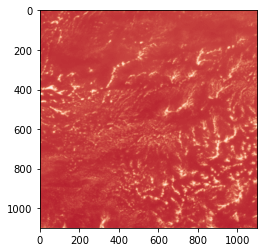

In [10]:
for i in range(10):
    print('Processing ', ds['time'][i].data, 'scene ', i+1, '/', len(ds['time']))
    
    # Select
    scene = ds.C13.isel(time=i)
    
    # Subset
    scene = scene.sel(lat=slice(lat1, lat0), lon=slice(lon0,lon1))
    
    # Resize
    # This operation will try to get, though access is unstable so need to build in fail-safes
    while True:
        try:
            imin = np.argmin(scene.shape)
            scene = resize(scene, (scene.shape[imin],scene.shape[imin]), anti_aliasing=True)
        except:
            print('Unable to access scene, retrying...')
            continue
        break
    
    # Plot scene
    plt.imshow(scene, cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Define cloud mask
    cloud_mask = np.zeros(scene.shape,dtype=int)
    cloud_mask[(scene < T_cl_max) & (scene > T_cl_min)] = 1
    
    # Test high clouds
    if np.percentile(test_sub_res[test_cm == 1], q_cutoff) < T_cutoff:
        print('Reject due to high clouds')
        continue
    
    # Compute selected metrics
    computed_object_labels = False
    computed_spectra = False
    for j in range(len(metrics)):
        
        # Cloud object metrics
        if metrics[j] in available_object_metrics.keys():
            print('Computing', metrics[j])
            
            # Compute object labels if not done yet
            if not computed_object_labels:
                object_labels = cloudmetrics.objects.label(cloud_mask)
                computed_object_labels = True
            
            # Compute metric
            fn_metric = available_object_metrics[metrics[j]]
            df_metrics.iloc[i].loc[metrics[j]] = fn_metric(object_labels)
        
        # Cloud mask metrics
        elif metrics[j] in available_mask_metrics.keys():
            print('Computing', metrics[j])
            fn_metric = available_mask_metrics[metrics[j]]
            
            # Open sky exception - just take the mean open sky area (second function output)
            if 'open_sky' in metrics[j]:
                _, df_metrics.iloc[i].loc[metrics[j]] = fn_metric(cloud_mask)
            else:
                df_metrics.iloc[i].loc[metrics[j]] = fn_metric(cloud_mask)

        # Cloud scalar metrics
        elif metrics[j] in available_scalar_metrics.keys():
            print('Computing', metrics[j])
            fn_metric = available_scalar_metrics[metrics[j]]
            
            # Spectral metrics exception
            if 'spectral' in metrics[j]:
                
                # Compute spectra if not done yet
                if not computed_spectra:
                    wavenumbers, psd_1d_radial, psd_1d_azimuthal = cloudmetrics.scalar.compute_spectra(scene)
                    computed_spectra = True
                
                # Compute metrics
                if 'anisotropy' in metrics[j]:
                    df_metrics.iloc[i].loc[metrics[j]] = fn_metric(psd_1d_azimuthal)
                else:
                    df_metrics.iloc[i].loc[metrics[j]] = fn_metric(wavenumbers, psd_1d_radial)
            
            # All other scalar metrics computed normally
            else:
                df_metrics.iloc[i].loc[metrics[j]] = fn_metric(scene)

df_metrics